<a href="https://colab.research.google.com/gist/rekalantar/2c303b69a11875dfba873aac11e44cfd/variationalautoencoder_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm

In [2]:
import random
import numpy as np
import torch

seed = 42
def set_seed(seed=42):
    """
    Set seed for reproducibility across numpy, torch, and random.

    Args:
        seed (int): The seed value to be set. Default is 42.
    """
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # Multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable auto-tuning for deterministic results

    print(f"Seed set to {seed}")

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import h5py
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
set_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths to the datasets
digits_path = "/kaggle/input/e2e-specific-task-1-dataset/rotated_digits.hdf5"

# Load the datasets
def load_data(path,digit):
    data = []
    with h5py.File(path, 'r') as f:
        for key in f.keys():
            if f"{digit}" in key:
                return f[key][:]

Seed set to 42
Using device: cuda


In [4]:
set_seed(seed)
print("Loading digit 1 data...")
digit_1 = load_data(digits_path,1)
print(f"digit_1 data shape: {digit_1.shape}")

print("Loading digit 2 data...")
digit_2 = load_data(digits_path,2)
print(f"digit_2 data shape: {digit_2.shape}")

Seed set to 42
Loading digit 1 data...
digit_1 data shape: (74162, 1, 28, 28)
Loading digit 2 data...
digit_2 data shape: (65538, 1, 28, 28)


In [5]:
set_seed(seed)
# Create a custom dataset class
class DigitDataset(Dataset):
    def __init__(self, digit_1, digit_2,set_z=False,mean_std=None, transform=None):
        # Assuming data is already in shape [N, 1, 28, 28]
        # If not, reshape it
        if len(digit_1.shape) == 3:
            digit_1 = digit_1.reshape(-1, 1, 28, 28)
        if len(digit_2.shape) == 3:
            digit_2 = digit_2.reshape(-1, 1, 28, 28)
        self.set_z = set_z      
        self.mean_std = mean_std
        
        self.data = np.concatenate([digit_1, digit_2], axis=0)
        self.labels = np.concatenate([np.zeros(len(digit_1)), np.ones(len(digit_2))])
        
        # Shuffle the data
        indices = np.random.permutation(len(self.data))
        self.data = self.data[indices]
        self.labels = self.labels[indices]
        self.transform = transform
        if set_z ==1: 
            self.data,self.mean_std = self._normalize(self.data)
        else : self.data = self._normalize(self.data)
        
    
    def _normalize(self, data):
        # Normalize each channel independently
        # if (self.set_z==0) and (self.mean_std is not None):
        #     print(f'using setted zs')
        #     for i in range(data.shape[1]):
        #         mean = self.mean_std['mean'][i]
        #         std = self.mean_std['std'][i]
        #         data[:, i] = (data[:, i] - mean) / (std + 1e-7)
        #     return data
        # else :
        #     print(f'setting zs')
        #     mean_std = {'mean':np.zeros(data.shape[1]),'std':np.zeros(data.shape[1])}
        #     for i in range(data.shape[1]):
        #         mean = np.mean(data[:, i])
        #         mean_std['mean'][i]=mean
        #         std = np.std(data[:, i])
        #         mean_std['std'][i]=std
        #         data[:, i] = (data[:, i] - mean) / (std + 1e-7)
        #     if self.set_z==1: 
        #         self.mean_std = mean_std
        #         return data, mean_std
        #     return data
        return data
        
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        
        # Convert to torch tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        
        if self.transform:
            x = self.transform(x)
            
        return x, y

Seed set to 42


In [6]:
set_seed(seed)
# Check if data is already in shape [N, 1, 28, 28] or needs reshaping
print(f"Original data shapes: Digit_1 - {digit_1.shape}, Digit_2 - {digit_2.shape}")

# Reshape if necessary
if len(digit_1.shape) == 3:
    digit_1 = np.stack([digit_1, np.zeros_like(digit_1)], axis=1)
if len(digit_2.shape) == 3:
    digit_2 = np.stack([digit_2, np.zeros_like(digit_2)], axis=1)

# If data is in shape [N, 32, 32, 2], transpose to [N, 2, 32, 32]
if digit_1.shape[-1] == 1:
    digit_1 = np.transpose(digit_1, (0, 3, 1, 2))
if digit_2.shape[-1] == 1:
    digit_2 = np.transpose(digit_2, (0, 3, 1, 2))

print(f"Processed data shapes: Digit_1 - {digit_1.shape}, Digit_2 - {digit_2.shape}")

Seed set to 42
Original data shapes: Digit_1 - (74162, 1, 28, 28), Digit_2 - (65538, 1, 28, 28)
Processed data shapes: Digit_1 - (74162, 1, 28, 28), Digit_2 - (65538, 1, 28, 28)


In [7]:
from sklearn.model_selection import train_test_split

set_seed(seed)
digit_1_t, digit_1_v = train_test_split(digit_1, test_size=0.2, random_state=seed)
digit_2_t, digit_2_v = train_test_split(digit_2, test_size=0.2, random_state=seed)

print(f'digit_1:{digit_1_t.shape}, {digit_1_v.shape}')
print(f'digit_2:{digit_2_t.shape}, {digit_2_v.shape}')

Seed set to 42
digit_1:(59329, 1, 28, 28), (14833, 1, 28, 28)
digit_2:(52430, 1, 28, 28), (13108, 1, 28, 28)


In [8]:
set_seed(seed)
# Create the dataset
train_dataset = DigitDataset(digit_1_t, digit_2_t,set_z=0)
test_dataset = DigitDataset(digit_1_v, digit_2_v,set_z=0,mean_std = train_dataset.mean_std)

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create data loaders
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Seed set to 42
Training set size: 111759
Test set size: 27941


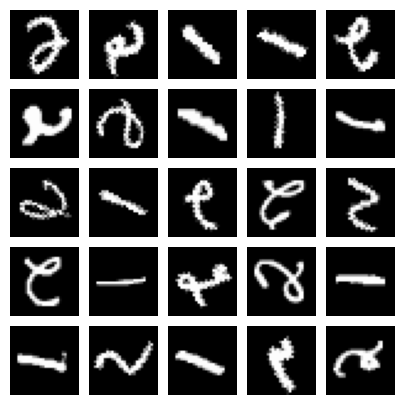

In [9]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [10]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=256):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)                     
        return mean, log_var

In [11]:
class Decoder(nn.Module):
    
    def __init__(self, output_dim=784, hidden_dim=512, latent_dim=256):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear2(x))
        x = self.LeakyReLU(self.linear1(x))
        
        x_hat = torch.sigmoid(self.output(x))
        return x_hat

In [12]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.decomposition import PCA

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD

def visualize_reconstructions(model, data_loader, device, x_dim=784, num_samples=10):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(data_loader))
        x = x[:num_samples].view(-1, x_dim).to(device)
        x_hat, _, _ = model(x)
        x_hat = x_hat.cpu().view(-1, 28, 28)
        x = x.cpu().view(-1, 28, 28)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples, 2))
    for i in range(num_samples):
        axes[0, i].imshow(x[i], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(x_hat[i], cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Reconstructed')
    plt.show()

def visualize_latent_space(model, train_loader, test_loader, device, x_dim=784):
    model.eval()
    train_means, test_means = [], []
    train_labels, test_labels = [], []
    with torch.no_grad():
        for x, y in train_loader:
            x = x.view(-1, x_dim).to(device)
            _, mean, _ = model(x)
            train_means.append(mean.cpu().numpy())
            train_labels.append(y.cpu().numpy())
        for x, y in test_loader:
            x = x.view(-1, x_dim).to(device)
            _, mean, _ = model(x)
            test_means.append(mean.cpu().numpy())
            test_labels.append(y.cpu().numpy())
    train_means = np.concatenate(train_means, axis=0)
    test_means = np.concatenate(test_means, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    
    pca = PCA(n_components=2)
    train_pca = pca.fit_transform(train_means)
    test_pca = pca.transform(test_means)
    
    plt.figure(figsize=(8,6))
    plt.scatter(train_pca[train_labels == 0, 0], train_pca[train_labels == 0, 1], alpha=0.5, label='Train 0', color='blue')
    plt.scatter(train_pca[train_labels == 1, 0], train_pca[train_labels == 1, 1], alpha=0.5, label='Train 1', color='red')
    plt.legend()
    plt.title('PCA of Train Latent Space')
    plt.show()
    
    plt.figure(figsize=(8,6))
    plt.scatter(test_pca[test_labels == 0, 0], test_pca[test_labels == 0, 1], alpha=0.5, label='Test 0', color='blue')
    plt.scatter(test_pca[test_labels == 1, 0], test_pca[test_labels == 1, 1], alpha=0.5, label='Test 1', color='red')
    plt.legend()
    plt.title('PCA of Test Latent Space')
    plt.show()

def interpolate_latent_space(model, data_loader, device, x_dim=784, num_steps=10):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(data_loader))
        x1, x2 = x[0].view(-1, x_dim).to(device), x[4].view(-1, x_dim).to(device)
        _, mean1, _ = model(x1)
        _, mean2, _ = model(x2)
        
        interpolated = torch.stack([mean1 * (1 - t) + mean2 * t for t in np.linspace(0, 1, num_steps)])
        reconstructed = model.decoder(interpolated).cpu().view(-1, 28, 28)
    
    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps, 1))
    for i in range(num_steps):
        axes[i].imshow(reconstructed[i], cmap='gray')
        axes[i].axis('off')
    plt.show()

def train(model, optimizer, epochs, device, x_dim=784, save_path='vae_model.pth'):
    model.to(device)
    best_loss = float('inf')
    train_losses, test_losses = [], []
    kl_losses, recon_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss, kl_loss, recon_loss = 0, 0, 0
        for x, _ in tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{epochs}'):
            x = x.view(-1, x_dim).to(device)
            x_hat, mean, log_var = model(x)
            recon, kl = loss_function(x, x_hat, mean, log_var)
            loss = recon + kl
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()/x.shape[0]
            recon_loss += recon.item()/x.shape[0]
            kl_loss += kl.item()/x.shape[0]
        
        train_loss /= len(train_loader)
        recon_loss /= len(train_loader)
        kl_loss /= len(train_loader)
        train_losses.append(train_loss)
        recon_losses.append(recon_loss)
        kl_losses.append(kl_loss)
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.view(-1, x_dim).to(device)
                x_hat, mean, log_var = model(x)
                recon, kl = loss_function(x, x_hat, mean, log_var)
                test_loss += (recon + kl).item()/x.shape[0]
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Recon Loss = {recon_loss:.4f}, KL Loss = {kl_loss:.4f}, Test Loss = {test_loss:.4f}")
        
        if test_loss < best_loss:
            best_loss = test_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at epoch {epoch+1} with test loss {best_loss:.4f}")
        
        if (epoch+1) % 5 == 0:
            visualize_reconstructions(model, test_loader, device)
            visualize_latent_space(model, train_loader, test_loader, device)
            interpolate_latent_space(model, test_loader, device)
    
    plt.figure(figsize=(10,5))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
    plt.plot(range(1, epochs+1), recon_losses, label='Reconstruction Loss')
    plt.plot(range(1, epochs+1), kl_losses, label='KL Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('VAE Training and Validation Loss')
    plt.show()
    
    return train_losses, test_losses

Seed set to 42


Training Epoch 1/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 1: Train Loss = 154.9119, Recon Loss = 149.7112, KL Loss = 5.2007, Test Loss = 142.5170
Model saved at epoch 1 with test loss 142.5170


Training Epoch 2/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 2: Train Loss = 138.8448, Recon Loss = 133.1914, KL Loss = 5.6534, Test Loss = 137.4900
Model saved at epoch 2 with test loss 137.4900


Training Epoch 3/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 3: Train Loss = 134.4573, Recon Loss = 128.5607, KL Loss = 5.8965, Test Loss = 133.0062
Model saved at epoch 3 with test loss 133.0062


Training Epoch 4/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 4: Train Loss = 131.2159, Recon Loss = 125.1489, KL Loss = 6.0669, Test Loss = 130.5340
Model saved at epoch 4 with test loss 130.5340


Training Epoch 5/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 5: Train Loss = 129.5993, Recon Loss = 123.4524, KL Loss = 6.1469, Test Loss = 129.1071
Model saved at epoch 5 with test loss 129.1071


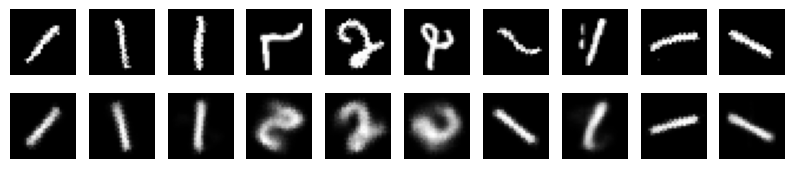

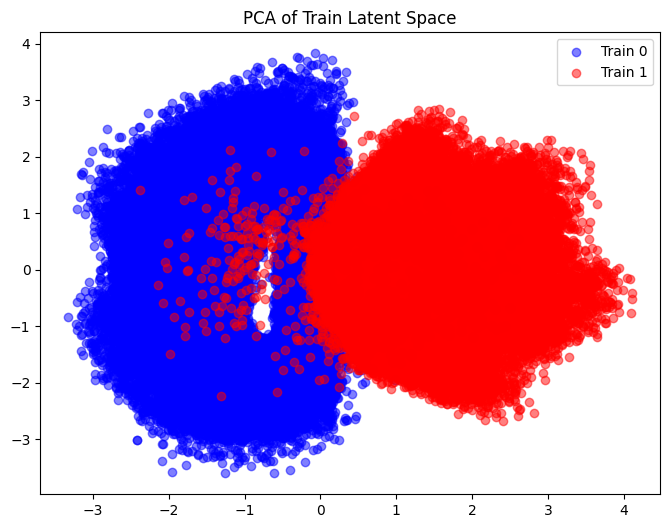

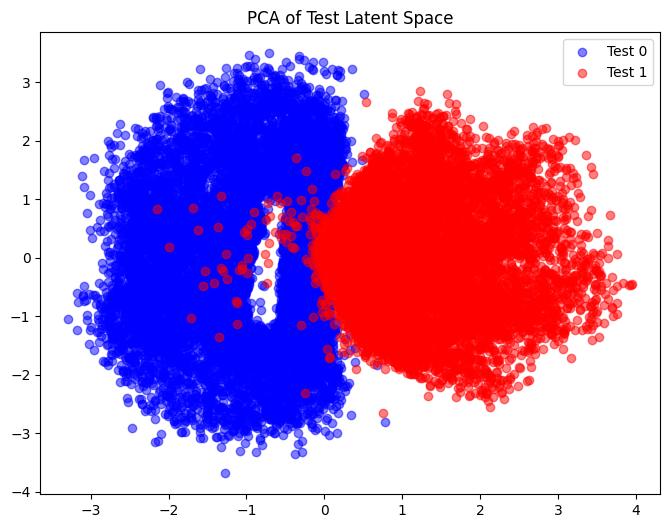

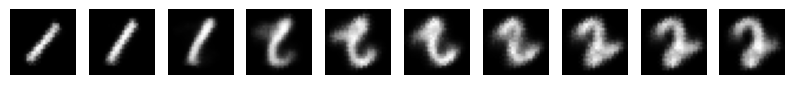

Training Epoch 6/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 6: Train Loss = 128.4200, Recon Loss = 122.2168, KL Loss = 6.2032, Test Loss = 128.9367
Model saved at epoch 6 with test loss 128.9367


Training Epoch 7/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 7: Train Loss = 127.4477, Recon Loss = 121.1943, KL Loss = 6.2534, Test Loss = 127.3747
Model saved at epoch 7 with test loss 127.3747


Training Epoch 8/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 8: Train Loss = 126.6514, Recon Loss = 120.3679, KL Loss = 6.2835, Test Loss = 126.7632
Model saved at epoch 8 with test loss 126.7632


Training Epoch 9/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 9: Train Loss = 126.0011, Recon Loss = 119.6791, KL Loss = 6.3220, Test Loss = 126.4390
Model saved at epoch 9 with test loss 126.4390


Training Epoch 10/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 10: Train Loss = 125.5515, Recon Loss = 119.2041, KL Loss = 6.3474, Test Loss = 126.1815
Model saved at epoch 10 with test loss 126.1815


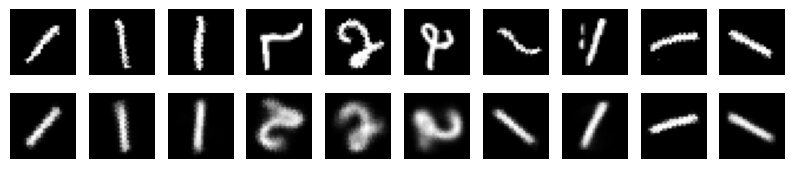

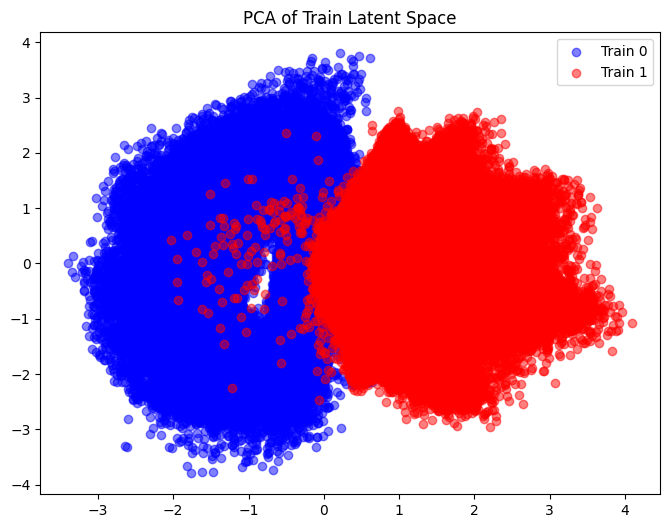

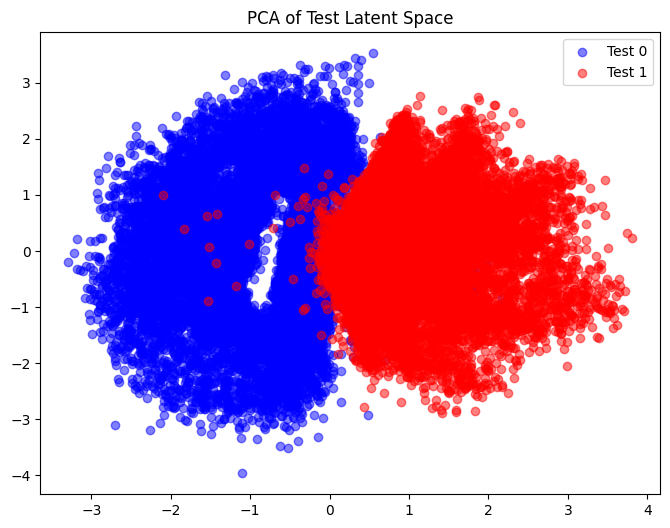

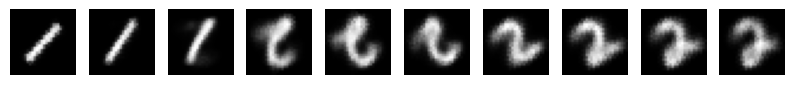

Training Epoch 11/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 11: Train Loss = 125.1665, Recon Loss = 118.7949, KL Loss = 6.3716, Test Loss = 125.8765
Model saved at epoch 11 with test loss 125.8765


Training Epoch 12/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 12: Train Loss = 124.7316, Recon Loss = 118.3409, KL Loss = 6.3907, Test Loss = 125.3452
Model saved at epoch 12 with test loss 125.3452


Training Epoch 13/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 13: Train Loss = 124.3794, Recon Loss = 117.9699, KL Loss = 6.4095, Test Loss = 125.0660
Model saved at epoch 13 with test loss 125.0660


Training Epoch 14/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 14: Train Loss = 124.1051, Recon Loss = 117.6675, KL Loss = 6.4376, Test Loss = 124.8411
Model saved at epoch 14 with test loss 124.8411


Training Epoch 15/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 15: Train Loss = 123.9042, Recon Loss = 117.4506, KL Loss = 6.4536, Test Loss = 124.4960
Model saved at epoch 15 with test loss 124.4960


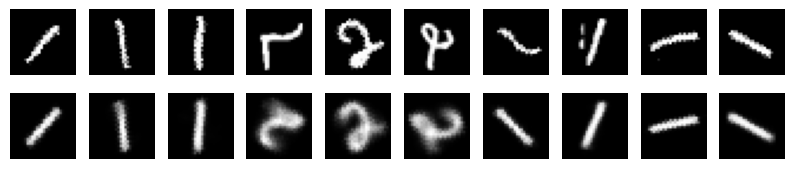

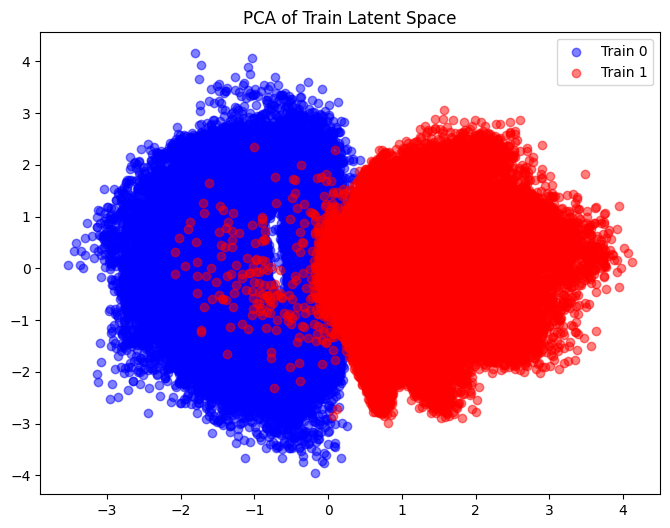

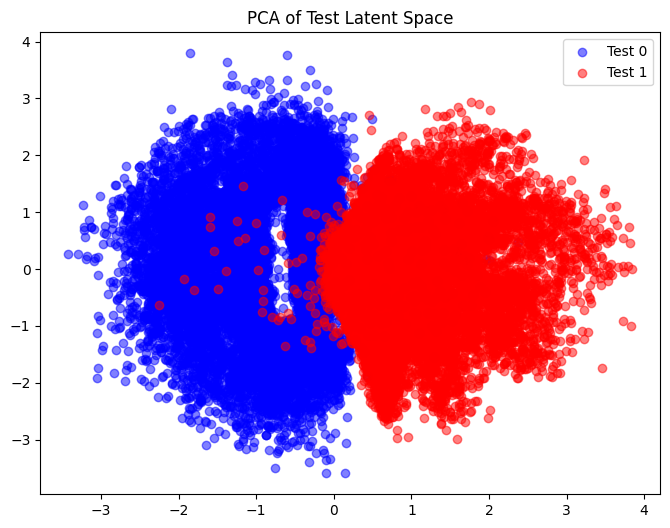

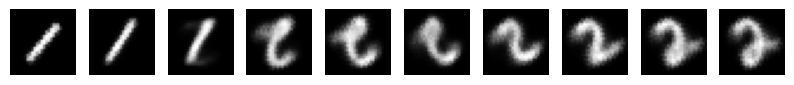

Training Epoch 16/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 16: Train Loss = 123.5219, Recon Loss = 117.0530, KL Loss = 6.4689, Test Loss = 124.2041
Model saved at epoch 16 with test loss 124.2041


Training Epoch 17/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 17: Train Loss = 123.2853, Recon Loss = 116.8030, KL Loss = 6.4824, Test Loss = 124.2567


Training Epoch 18/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 18: Train Loss = 123.0755, Recon Loss = 116.5665, KL Loss = 6.5089, Test Loss = 124.3004


Training Epoch 19/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 19: Train Loss = 122.7620, Recon Loss = 116.2362, KL Loss = 6.5258, Test Loss = 123.7700
Model saved at epoch 19 with test loss 123.7700


Training Epoch 20/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 20: Train Loss = 122.7544, Recon Loss = 116.2211, KL Loss = 6.5333, Test Loss = 124.6405


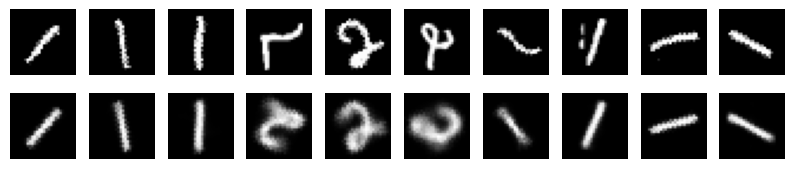

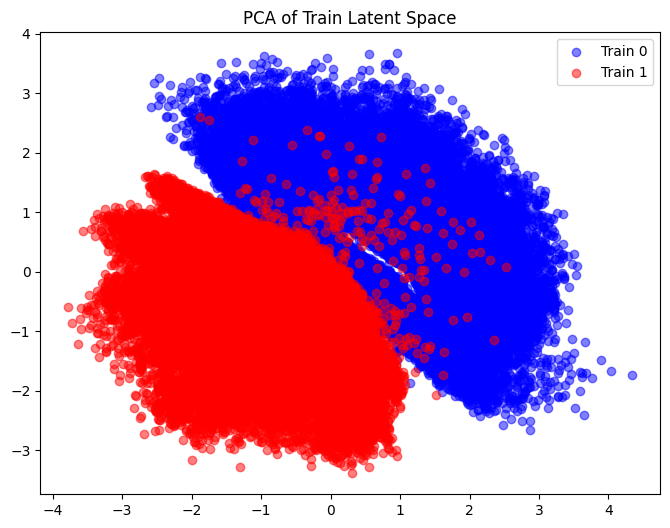

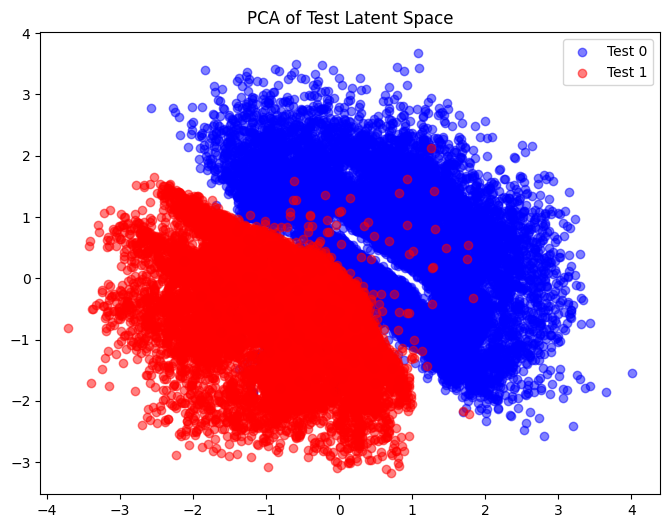

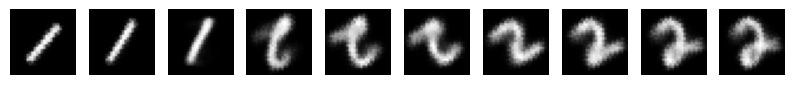

Training Epoch 21/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 21: Train Loss = 122.3980, Recon Loss = 115.8483, KL Loss = 6.5497, Test Loss = 123.2358
Model saved at epoch 21 with test loss 123.2358


Training Epoch 22/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 22: Train Loss = 122.3024, Recon Loss = 115.7344, KL Loss = 6.5680, Test Loss = 124.3837


Training Epoch 23/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 23: Train Loss = 122.1165, Recon Loss = 115.5364, KL Loss = 6.5801, Test Loss = 123.2651


Training Epoch 24/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 24: Train Loss = 121.8601, Recon Loss = 115.2614, KL Loss = 6.5987, Test Loss = 123.0088
Model saved at epoch 24 with test loss 123.0088


Training Epoch 25/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 25: Train Loss = 121.7482, Recon Loss = 115.1322, KL Loss = 6.6160, Test Loss = 123.0966


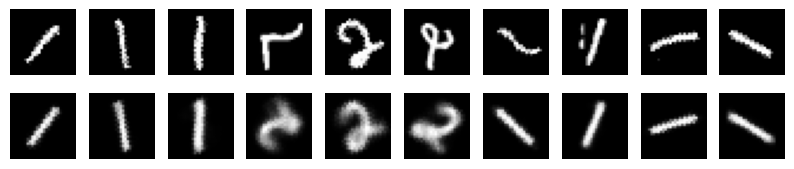

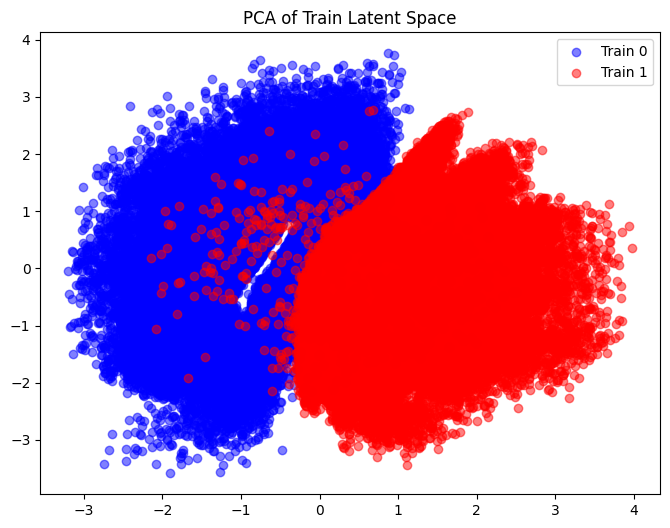

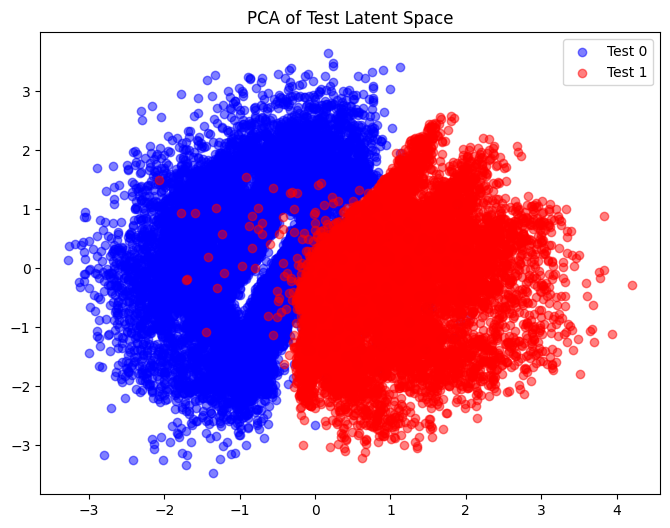

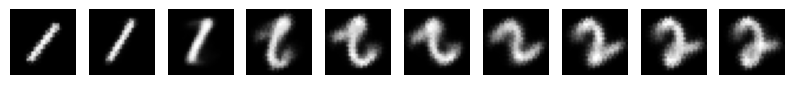

Training Epoch 26/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 26: Train Loss = 121.5174, Recon Loss = 114.8981, KL Loss = 6.6193, Test Loss = 123.0079
Model saved at epoch 26 with test loss 123.0079


Training Epoch 27/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 27: Train Loss = 121.4461, Recon Loss = 114.8129, KL Loss = 6.6332, Test Loss = 123.7464


Training Epoch 28/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 28: Train Loss = 121.3425, Recon Loss = 114.6853, KL Loss = 6.6572, Test Loss = 123.1567


Training Epoch 29/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 29: Train Loss = 121.2286, Recon Loss = 114.5723, KL Loss = 6.6563, Test Loss = 123.1932


Training Epoch 30/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 30: Train Loss = 121.0015, Recon Loss = 114.3217, KL Loss = 6.6798, Test Loss = 122.3047
Model saved at epoch 30 with test loss 122.3047


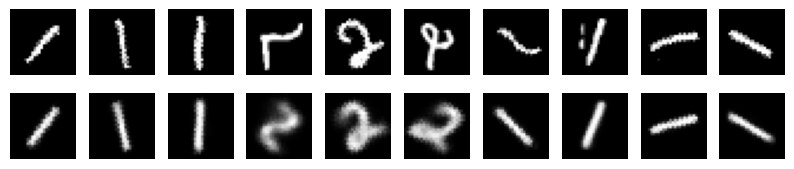

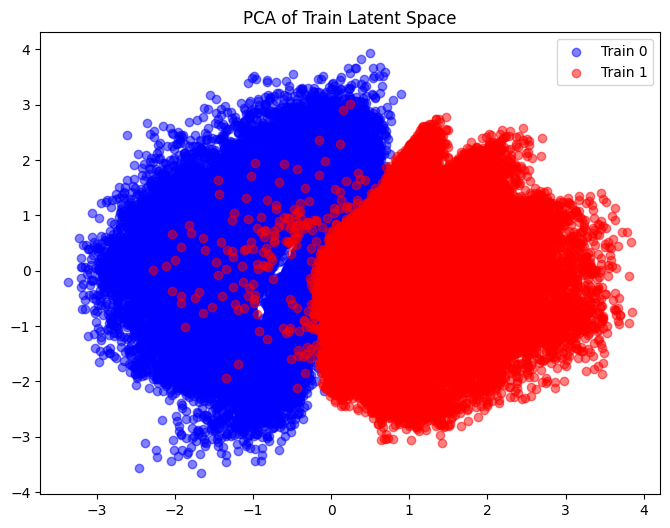

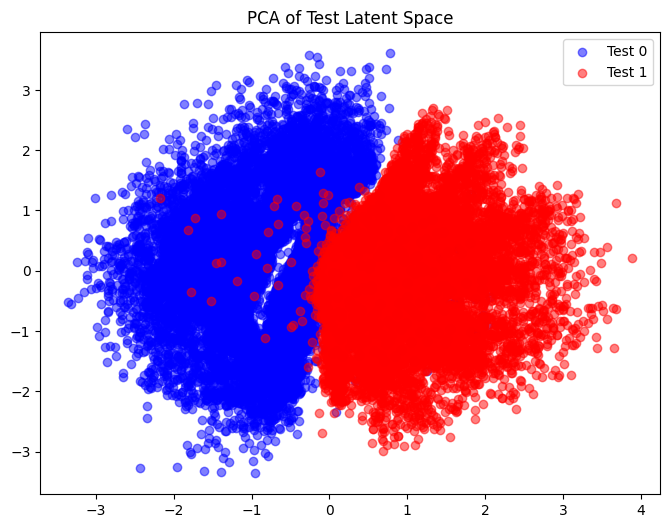

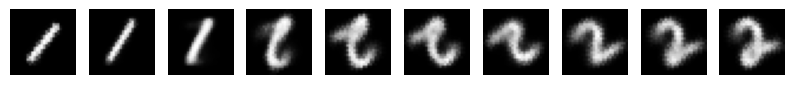

Training Epoch 31/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 31: Train Loss = 120.8674, Recon Loss = 114.1735, KL Loss = 6.6939, Test Loss = 122.7967


Training Epoch 32/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 32: Train Loss = 120.8012, Recon Loss = 114.1098, KL Loss = 6.6914, Test Loss = 122.2093
Model saved at epoch 32 with test loss 122.2093


Training Epoch 33/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 33: Train Loss = 120.6934, Recon Loss = 113.9885, KL Loss = 6.7049, Test Loss = 122.5147


Training Epoch 34/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 34: Train Loss = 120.5023, Recon Loss = 113.7831, KL Loss = 6.7192, Test Loss = 123.0808


Training Epoch 35/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 35: Train Loss = 120.3642, Recon Loss = 113.6256, KL Loss = 6.7386, Test Loss = 122.5793


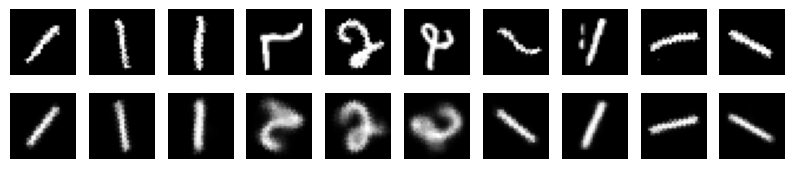

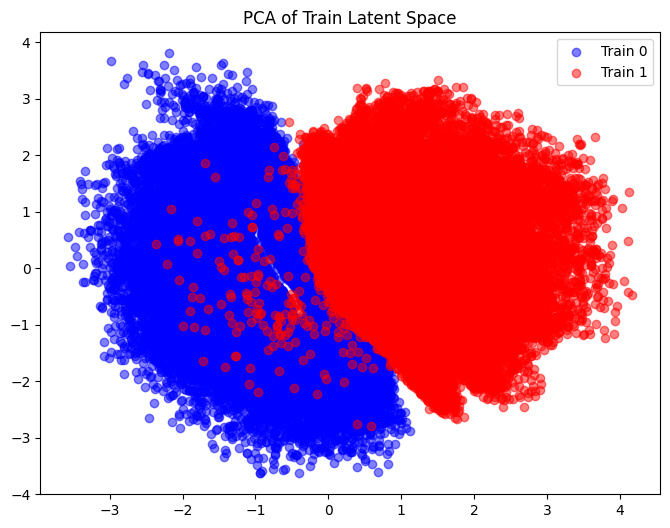

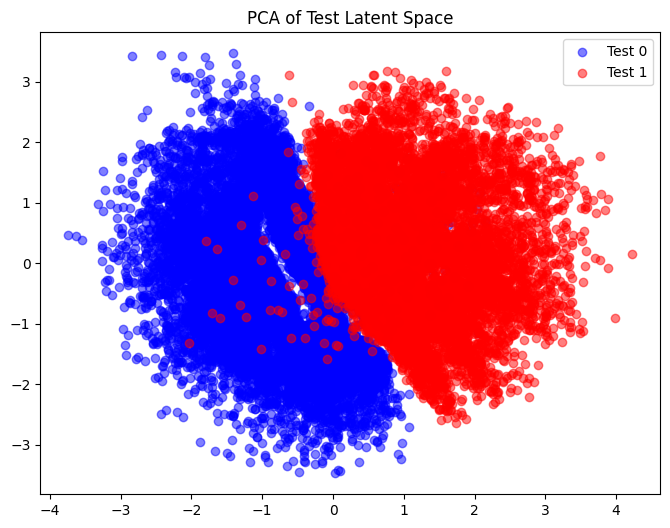

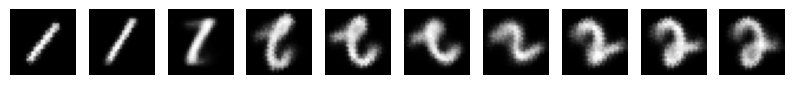

Training Epoch 36/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 36: Train Loss = 120.3126, Recon Loss = 113.5775, KL Loss = 6.7351, Test Loss = 122.0067
Model saved at epoch 36 with test loss 122.0067


Training Epoch 37/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 37: Train Loss = 120.1902, Recon Loss = 113.4430, KL Loss = 6.7472, Test Loss = 122.5418


Training Epoch 38/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 38: Train Loss = 120.0002, Recon Loss = 113.2390, KL Loss = 6.7612, Test Loss = 122.2953


Training Epoch 39/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 39: Train Loss = 119.9604, Recon Loss = 113.1854, KL Loss = 6.7751, Test Loss = 122.1903


Training Epoch 40/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 40: Train Loss = 119.8951, Recon Loss = 113.1119, KL Loss = 6.7832, Test Loss = 122.7369


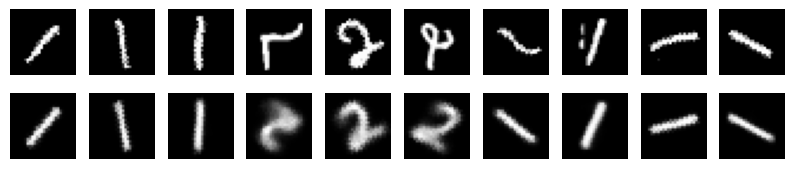

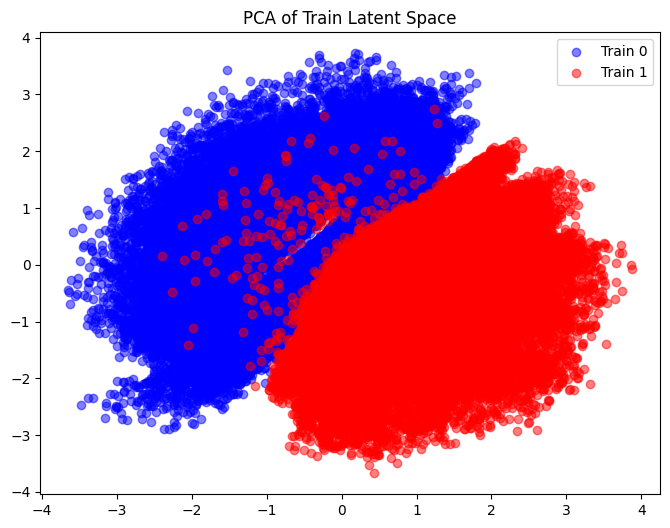

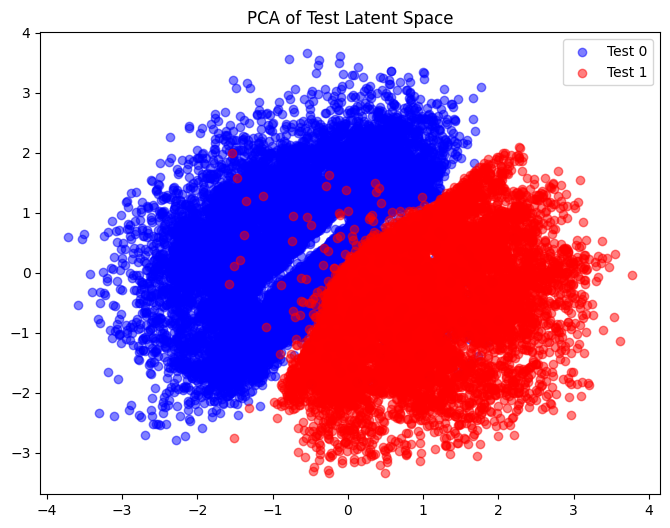

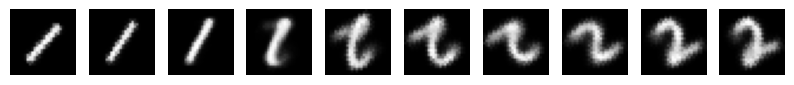

Training Epoch 41/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 41: Train Loss = 119.9082, Recon Loss = 113.1243, KL Loss = 6.7839, Test Loss = 124.3562


Training Epoch 42/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 42: Train Loss = 119.7793, Recon Loss = 112.9794, KL Loss = 6.8000, Test Loss = 121.7804
Model saved at epoch 42 with test loss 121.7804


Training Epoch 43/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 43: Train Loss = 119.6585, Recon Loss = 112.8481, KL Loss = 6.8105, Test Loss = 122.0011


Training Epoch 44/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 44: Train Loss = 119.6010, Recon Loss = 112.7839, KL Loss = 6.8171, Test Loss = 122.2912


Training Epoch 45/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 45: Train Loss = 119.4389, Recon Loss = 112.6102, KL Loss = 6.8287, Test Loss = 122.3859


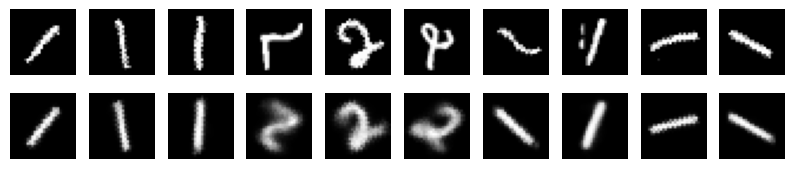

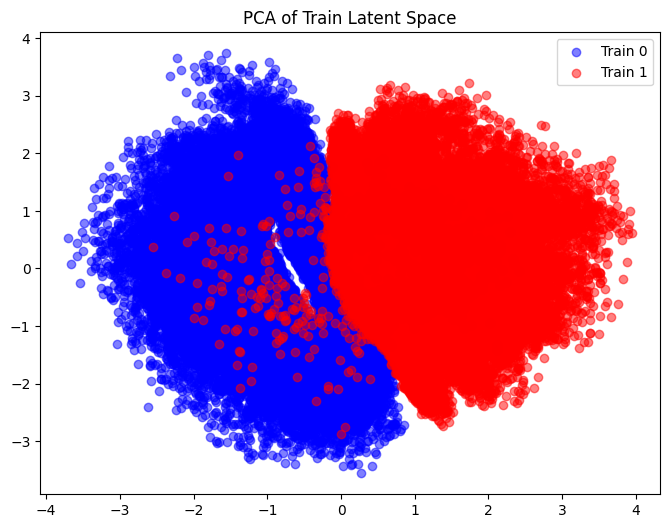

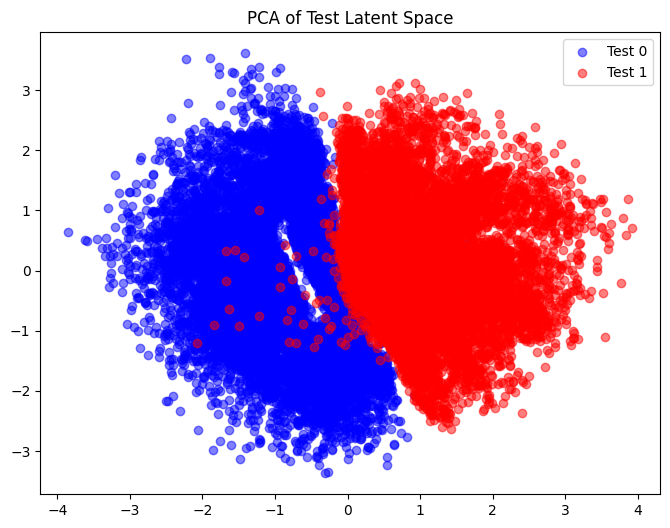

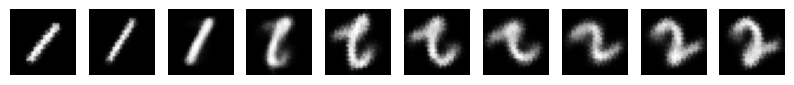

Training Epoch 46/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 46: Train Loss = 119.4273, Recon Loss = 112.5970, KL Loss = 6.8303, Test Loss = 122.5932


Training Epoch 47/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 47: Train Loss = 119.2967, Recon Loss = 112.4640, KL Loss = 6.8328, Test Loss = 121.4455
Model saved at epoch 47 with test loss 121.4455


Training Epoch 48/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 48: Train Loss = 119.0733, Recon Loss = 112.2284, KL Loss = 6.8449, Test Loss = 121.8280


Training Epoch 49/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 49: Train Loss = 119.1189, Recon Loss = 112.2673, KL Loss = 6.8516, Test Loss = 121.9993


Training Epoch 50/50:   0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 50: Train Loss = 119.1952, Recon Loss = 112.3464, KL Loss = 6.8489, Test Loss = 121.7893


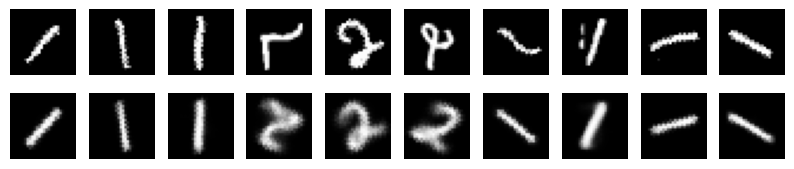

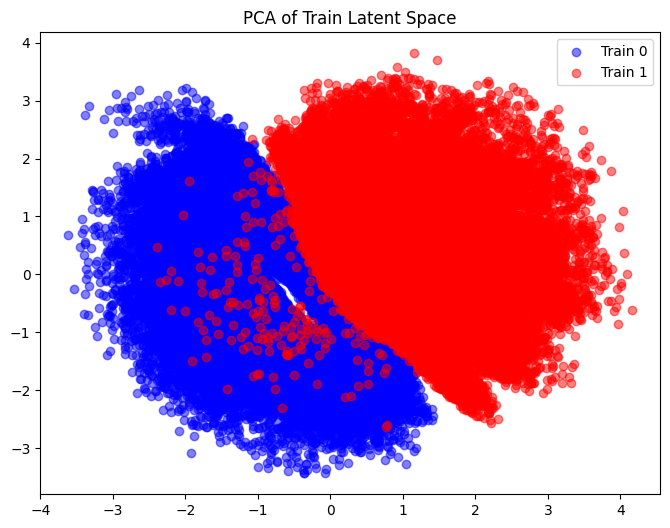

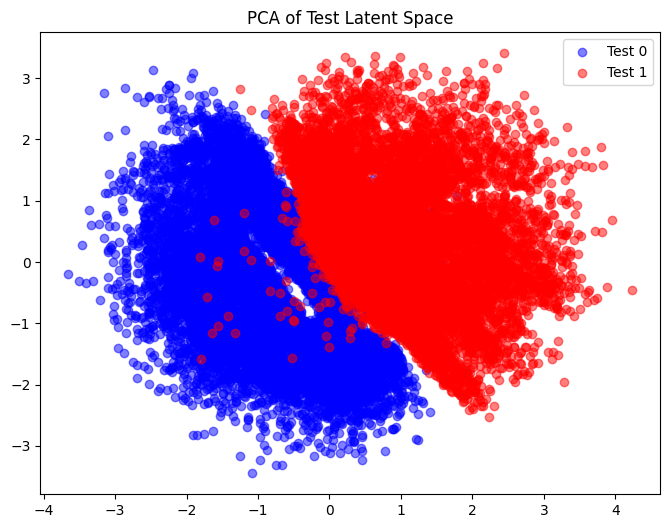

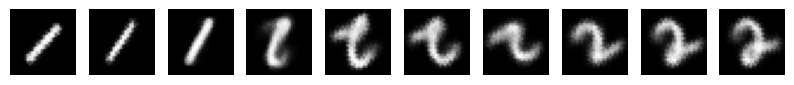

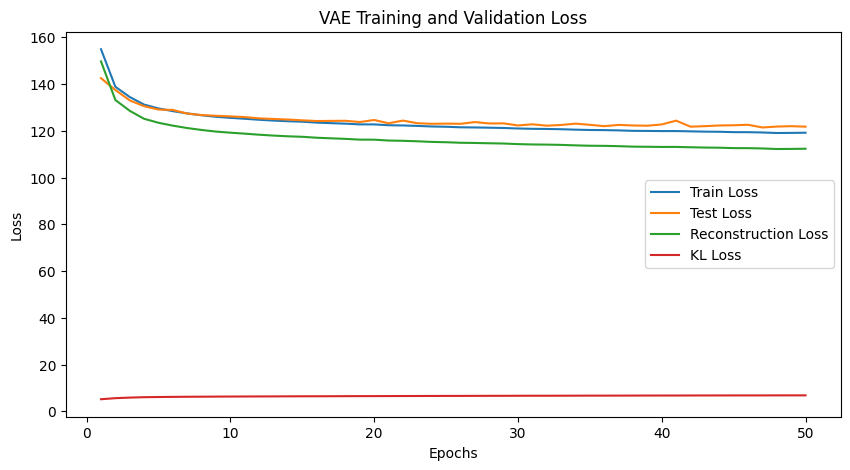

([154.91187291324604,
  138.84476753601976,
  134.4572544277388,
  131.21585111947735,
  129.59933550445612,
  128.42000553334094,
  127.44772147813318,
  126.65138245670823,
  126.0010595541751,
  125.55151191586285,
  125.1664558362852,
  124.73161484903227,
  124.37941644831378,
  124.10512845952621,
  123.90416165036315,
  123.52194986821259,
  123.28534798133634,
  123.07545039011579,
  122.76201732507938,
  122.75442121017015,
  122.39797074984936,
  122.3024453384383,
  122.11652546592298,
  121.86014825001041,
  121.74817037280353,
  121.517441974315,
  121.44610111633858,
  121.34248672383114,
  121.22856081792354,
  121.00146106642121,
  120.86737858584168,
  120.80121534018883,
  120.69340632719282,
  120.50227297742217,
  120.36419707099952,
  120.31258651124989,
  120.1901736360162,
  120.00015541959178,
  119.96044501992507,
  119.89509188084845,
  119.90820201907188,
  119.77934731227234,
  119.65854958453822,
  119.60102847982078,
  119.43891787690018,
  119.42727763238

In [14]:
set_seed(seed)
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
train(model, optimizer, epochs=50, device=device)

  0%|          | 0/1118 [00:00<?, ?it/s]

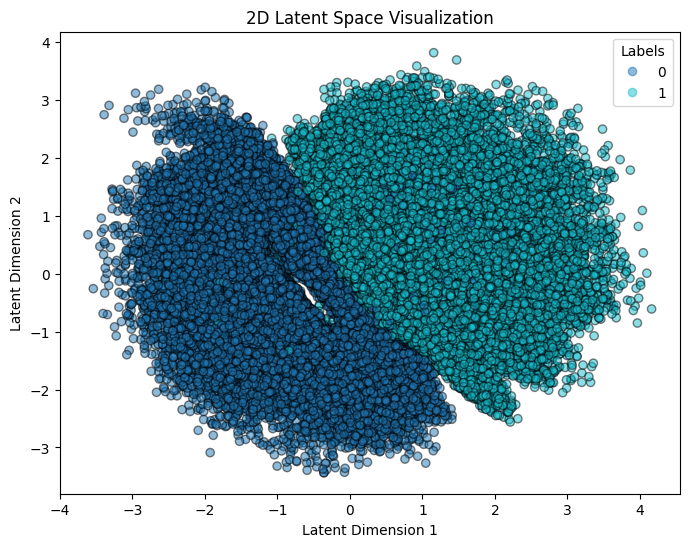

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Move model to evaluation mode
model.eval()

# Extract means and variances from encoder
means_list, variances_list, labels_list = [], [], []

with torch.no_grad():
    for batch in tqdm(train_loader,total = len(train_loader)):  # Assuming train_dataset is iterable (like DataLoader)
        x, labels = batch  # Extract input data and labels
        x = x.view(-1, 784).to(device)
        x = x.to(device)  # Move to model's device
        
        # Pass through encoder
        mean, log_var = model.encode(x)  # Encoder outputs mean and log variance
        var = torch.exp(log_var)  # Convert log variance to actual variance
        
        means_list.append(mean.cpu().numpy())
        variances_list.append(var.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Convert lists to numpy arrays
means = np.concatenate(means_list, axis=0)
variances = np.concatenate(variances_list, axis=0)
labels = np.concatenate(labels_list, axis=0)  # Assuming labels exist
means  = PCA(n_components=2).fit_transform(means,)

# Scatter plot with colors based on labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(means[:, 0], means[:, 1], c=labels, cmap='tab10', alpha=0.5, edgecolors='k')

# Add color legend
plt.legend(*scatter.legend_elements(), title="Labels")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Latent Space Visualization")

plt.show()

In [16]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

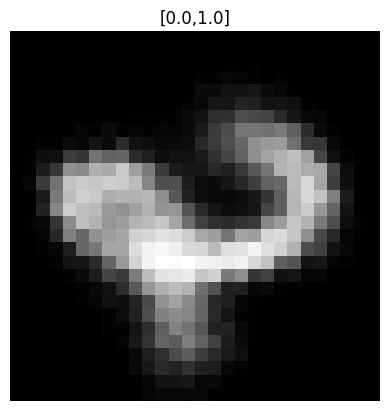

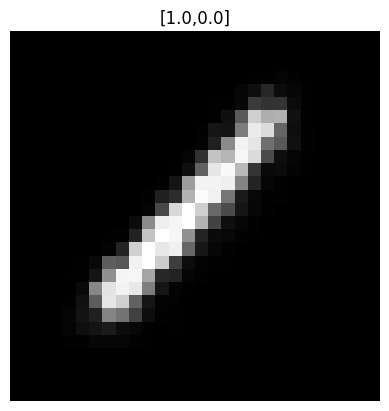

(None, None)

In [17]:
#img1: mean0, var1 / img2: mean1, var0
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

In [18]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

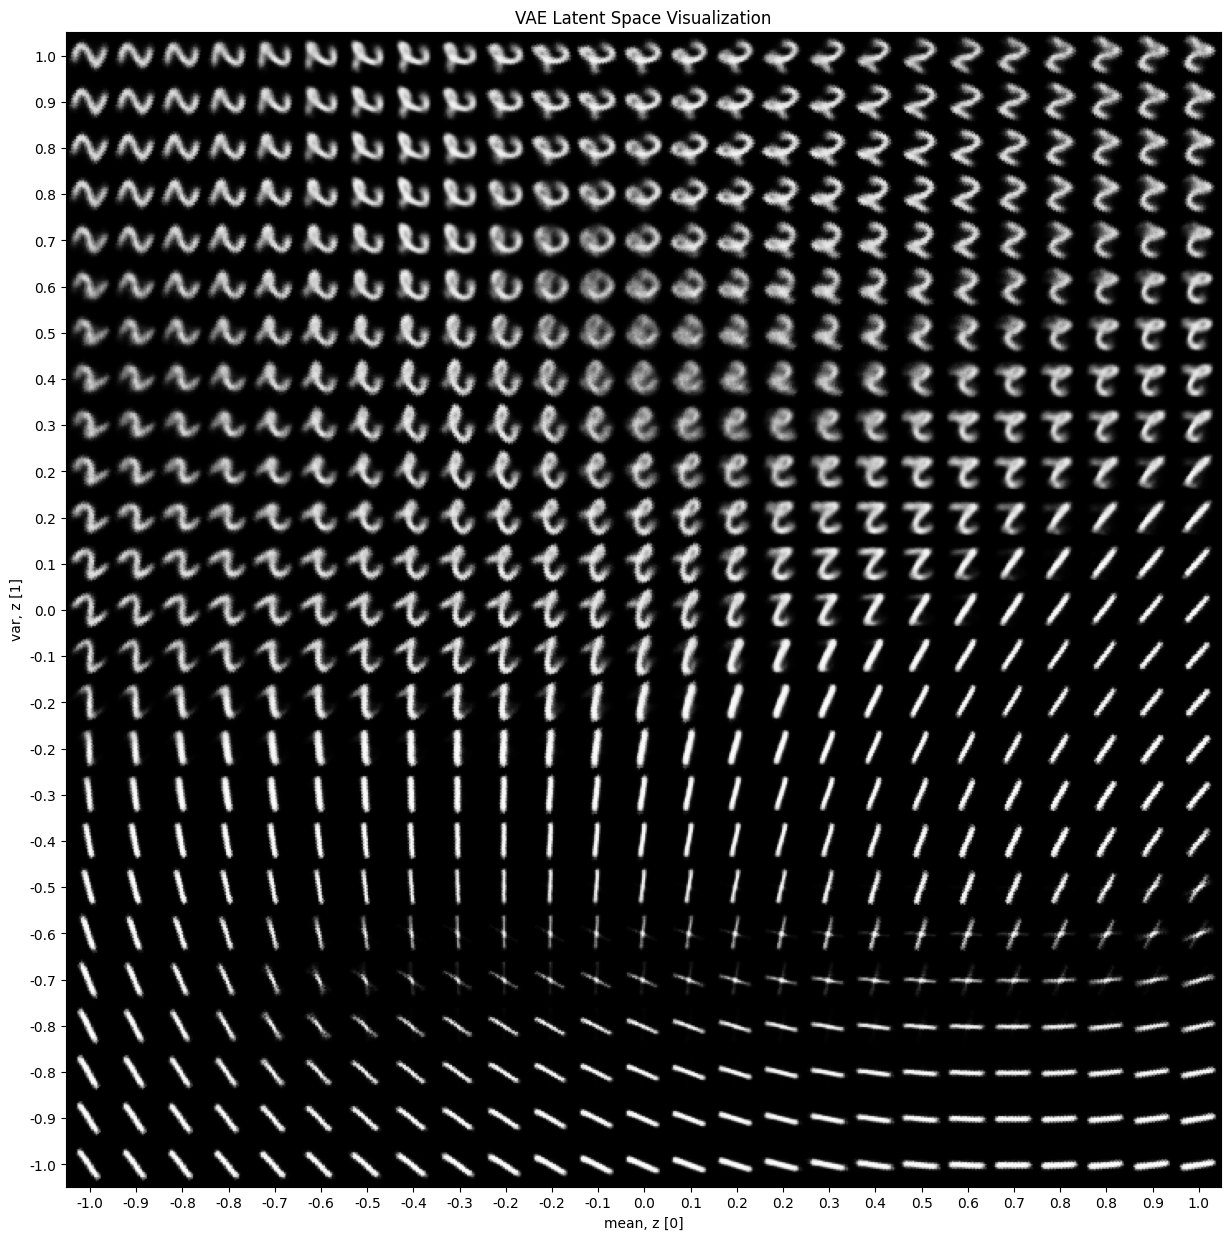

In [19]:
plot_latent_space(model, scale=1.0)

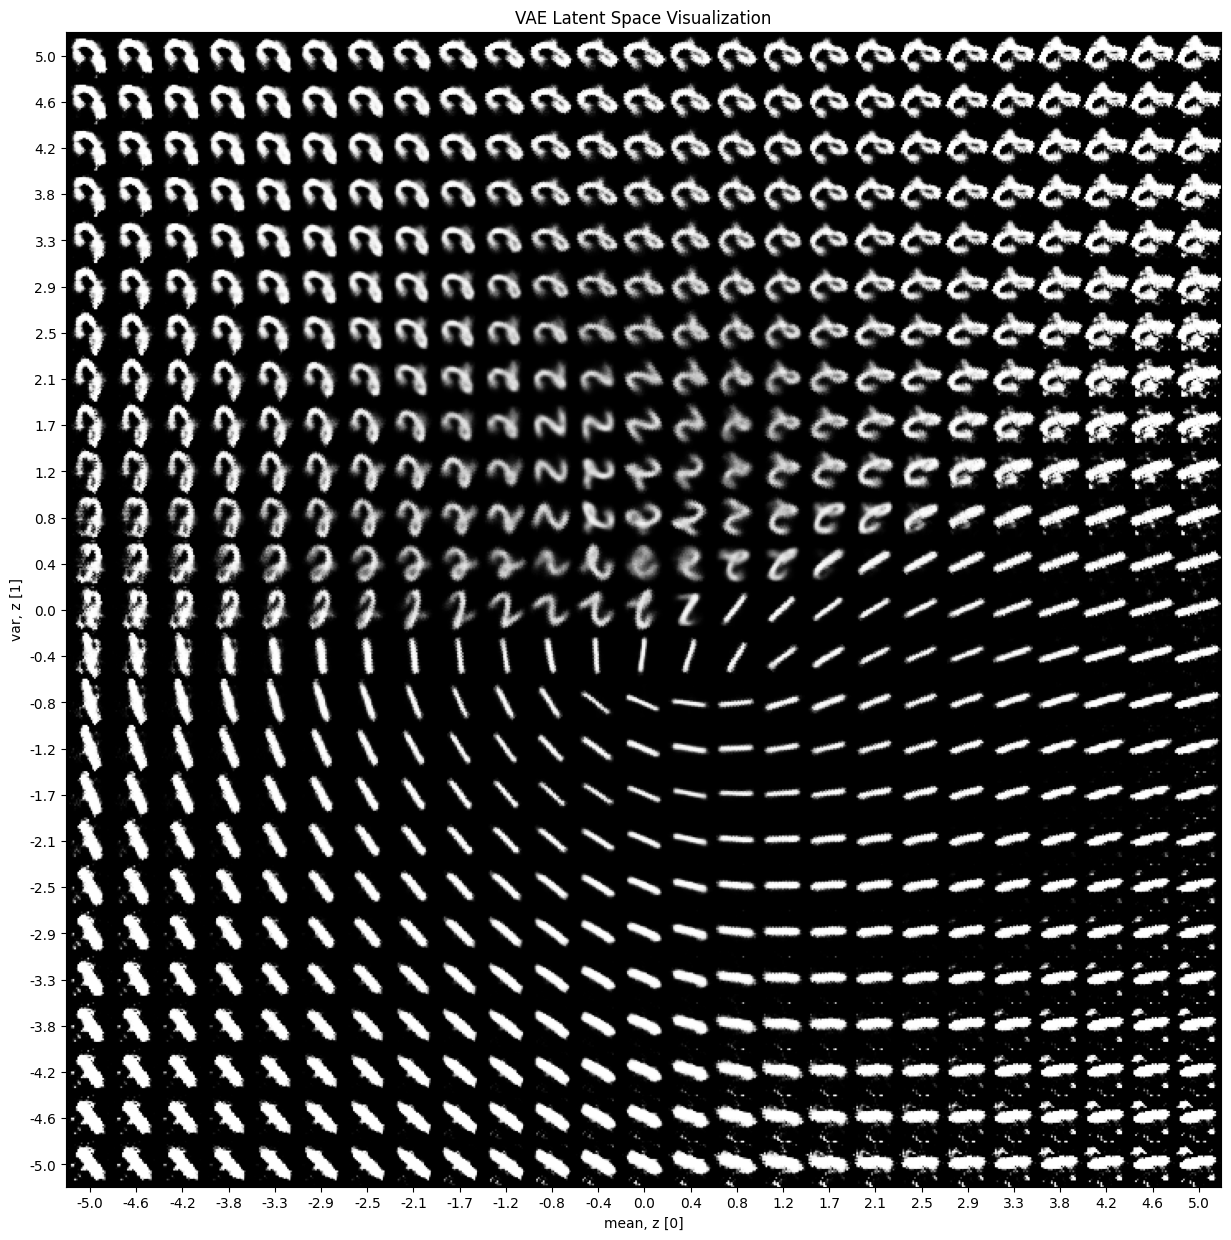

In [20]:
plot_latent_space(model, scale=5.0)

In [21]:
# torch.save(model.state_dict(),'model.pth')

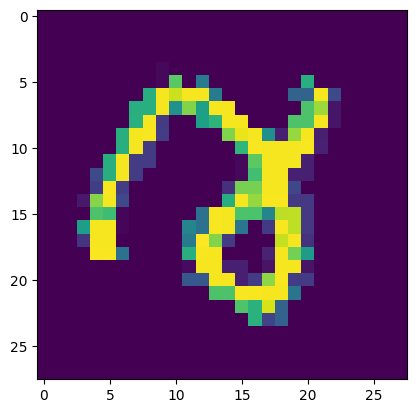

In [22]:
plt.imshow(train_dataset[0][0].squeeze())

tensor([[0.0884, 0.6010]], device='cuda:0')


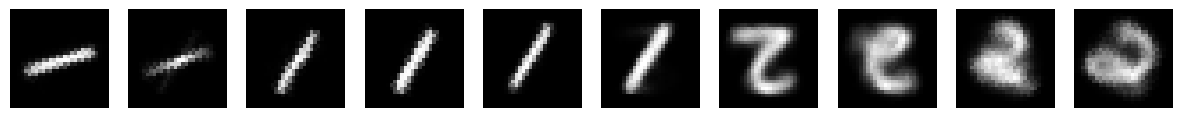

In [23]:
import numpy as np

model.eval()

# Select two random images
img1, _ = train_dataset[5698]
img2, _ = train_dataset[5699]

img1 = img1.unsqueeze(0).view((-1,784)).to(device)
img2 = img2.unsqueeze(0).view((-1,784)).to(device)

with torch.no_grad():
    mean1, _ = model.encode(img1)
    print(mean1)
    mean2, _ = model.encode(img2)

# Generate interpolated latent vectors
alphas = np.linspace(0, 1, num=10)  # 10 interpolation steps
interpolated_z = torch.stack([alpha * mean1 + (1 - alpha) * mean2 for alpha in alphas])

# Decode interpolated vectors
with torch.no_grad():
    interpolated_images = model.decoder(interpolated_z)

# Plot interpolation results
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    axes[i].imshow(interpolated_images[i].cpu().squeeze().view((28,28)), cmap='gray')
    axes[i].axis('off')

plt.show()